In [1]:
from factor_analysis_adv import *

#时间
import datetime

#算法辅助&数据
from sklearn.model_selection import KFold,cross_validate   #交叉验证
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split     #训练集测试集拆分

#算法（单一学习器）                          
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier   
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

#融合模型
from sklearn.ensemble import VotingClassifier


# 关闭警告
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

### 1 数据导入

In [ ]:
# 基准指数
index_item = '000300.XSHG'
# 机器学习数据
data = pd.read_pickle('./data/ml_data.pkl')
# 研究周期
date_list = sorted(set(data.index.get_level_values(0)))                                    # 研究周期确定
# 特征集
x = data.loc[:,:'AMP20']                                                                 
# 目标集合
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 特征名称
features = x.columns.tolist()                                                        

#### randomforest

In [ ]:
def best_estimetor_RandomForestClassifier(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for j in tqdm(range(3,8,2)):
        for t in np.logspace(-8,-5,3):
            for z in range(int(np.sqrt(len(fatcors))),len(fatcors)-1,4):
                clf = RandomForestClassifier(n_estimators=10,
                                             criterion='gini',
                                             max_features= z,
                                             max_depth=j,
                                             class_weight='balanced',
                                             ccp_alpha=t,
                                             random_state = 0,
                                             n_jobs = -2)         #生成随机森林
                precision_postive_cv = 0
                for i in range(1,6):
                    data_train = data_train_input[data_train_input.label != i]
                    data_validation = data_train_input[data_train_input.label == i]
                    x_train = data_train.loc[:,fatcors]
                    y_train = data_train.loc[:,'target']
                    x_val = data_validation.loc[:,fatcors]
                    y_val = data_validation.loc[:,'target']
                    clf.fit(x_train,y_train)
                    y_hat = clf.predict(x_val)                                          # 训练模型
                    martrix = confusion_matrix(y_val, y_hat)
                    metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
                    precision_postive_cv += metric
                temp = pd.DataFrame([j,t,z,precision_postive_cv/5],index = ['max_depth','ccp_alpha','max_features','precision_postive_cv'])
                precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

In [5]:
pre_gap = 240 * 2        # 预计算
ret_gap = 5              # 预测收益
predict_gap = 60         # 预测长度

# 滚动周期
trade_days = sorted(list(set(data.index.get_level_values(0).tolist())))
re_train_days = trade_days[pre_gap::predict_gap]

In [ ]:

def get_siganl_delay(x_test,T = 5):
    # 时间获取
    start_date = x_test.index.get_level_values(0).min()
    end_date = x_test.index.get_level_values(0).max()
    date_list = pd.to_datetime(get_trading_dates(start_date,end_date))
    # 信号数字化
    predict_signal = x_test['predict'].astype(int)
    # 信号递延
    predict_signal = predict_signal.unstack().fillna(0).reindex(date_list).unstack()
    predict_signal_delay = pd.DataFrame({i:predict_signal.groupby(level=0).apply(lambda x:x.shift(i)) for i in range(1,T+1)}).sort_index()
    # 信号叠加
    predict_signal_delay['signal_level'] = predict_signal_delay.sum(axis = 1)
    predict_signal_delay = predict_signal_delay.droplevel(0)
    predict_signal_cum = predict_signal_delay.signal_level.unstack('order_book_id')

    return predict_signal_cum,predict_signal_delay

#### xgboost

In [ ]:
def best_estimetor_XGBoost(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for max_depth_level in tqdm([3,6,9]):
        for eta_level in [0.8,1,1.2]:
            for gamma_level in [0.001, 0.01, 0.1]:
                clf = XGBClassifier(max_depth=max_depth_level,eta = eta_level,gamma = gamma_level)
                precision_postive_cv = 0
                for i in range(1,6):
                    data_train = data_train_input[data_train_input.label != i]
                    data_validation = data_train_input[data_train_input.label == i]
                    x_train = data_train.loc[:,fatcors]
                    y_train = data_train.loc[:,'target']
                    x_val = data_validation.loc[:,fatcors]
                    y_val = data_validation.loc[:,'target']
                    clf.fit(x_train,y_train)
                    y_hat = clf.predict(x_val)                                          # 训练模型
                    martrix = confusion_matrix(y_val, y_hat)
                    metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
                    precision_postive_cv += metric
                temp = pd.DataFrame([max_depth_level,eta_level,gamma_level,precision_postive_cv/5],index = ['max_depth_level','eta_level','gamma_level','precision_postive_cv'])
                precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

#### KNN

In [ ]:
def best_estimetor_knn(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for n_neighbors_num in tqdm(range(3,12,4)):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors_num,n_jobs = -2)         
        precision_postive_cv = 0
        for i in range(1,6):
            data_train = data_train_input[data_train_input.label != i]
            data_validation = data_train_input[data_train_input.label == i]
            x_train = data_train.loc[:,fatcors]
            y_train = data_train.loc[:,'target']
            x_val = data_validation.loc[:,fatcors]
            y_val = data_validation.loc[:,'target']
            clf.fit(x_train,y_train)
            y_hat = clf.predict(x_val)                                          # 训练模型
            martrix = confusion_matrix(y_val, y_hat)
            metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 
            precision_postive_cv += metric
        temp = pd.DataFrame([n_neighbors_num,precision_postive_cv/5],index = ['n_neighbors_num','precision_postive_cv'])
        precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

    模型精确率排名作为权重
    

In [ ]:
model_name = 'vote_metric_rank'
data_test_total = pd.DataFrame()
rf_record = {}
xgb_record = {}
knn_record = {}

for i in tqdm(re_train_days):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end].fillna(0)
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end].fillna(0)
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    print(i)
    record_date = test_start.strftime('%F')
    
    paramter_rf = rf_record[record_date]
    paramter_xgb = xgb_record[record_date]
    paramter_knn = knn_record[record_date]

    # 模型输出
    clf_rf = RandomForestClassifier(n_estimators = 10,
                                    criterion = 'gini',
                                    max_features = int(paramter_rf['max_features']),
                                    max_depth = int(paramter_rf['max_depth']),
                                    class_weight = 'balanced',
                                    ccp_alpha = paramter_rf['ccp_alpha'],
                                    random_state = 0)
    
    clf_xgb = XGBClassifier(max_depth = int(paramter_xgb['max_depth_level']),
                            eta = paramter_xgb['eta_level'],
                            gamma = paramter_xgb['gamma_level'])
    
    clf_knn = KNeighborsClassifier(n_neighbors=int(paramter_knn['n_neighbors_num']),
                                   n_jobs = -2)    

    # 投票法
    estimators_voting1 =[('DecisionTreeClassifier',clf_rf),
                        ('RandomForestClassifier',clf_xgb),
                        ('KNeighborsClassifier',clf_knn)] 
    
    weight_series = pd.Series({'weight_clf_rf':paramter_rf['precision_postive_cv'],
                            'weight_clf_xgb':paramter_xgb['precision_postive_cv'],
                            'weight_clf_knn':paramter_knn['precision_postive_cv']})
    
    weight_series_rank = weight_series.rank(ascending = True)
    print(weight_series_rank.to_dict())

    clf_voting = VotingClassifier(estimators_voting1,
                                voting = 'soft',
                                weights = [weight_series_rank['weight_clf_rf'],
                                            weight_series_rank['weight_clf_xgb'],
                                            weight_series_rank['weight_clf_knn']],
                                n_jobs = -2)


    # 预测结果输出
    y_hat = clf_voting.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)


create_dir_not_exist('./data')
data_test_total.to_pickle(f'./data/data_test_total_{model_name}.pkl')

  0%|          | 0/12 [00:00<?, ?it/s]

2021-12-17 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


  8%|▊         | 1/12 [00:06<01:12,  6.61s/it]

2022-03-21 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


 17%|█▋        | 2/12 [00:12<01:00,  6.05s/it]

2022-06-21 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 1.0, 'weight_clf_knn': 2.0}


 25%|██▌       | 3/12 [00:16<00:48,  5.44s/it]

2022-09-14 00:00:00
{'weight_clf_rf': 2.0, 'weight_clf_xgb': 3.0, 'weight_clf_knn': 1.0}


 33%|███▎      | 4/12 [00:22<00:43,  5.38s/it]

2022-12-14 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


 42%|████▏     | 5/12 [00:28<00:39,  5.61s/it]

2023-03-16 00:00:00
{'weight_clf_rf': 1.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 3.0}


 50%|█████     | 6/12 [00:35<00:37,  6.29s/it]

2023-06-14 00:00:00
{'weight_clf_rf': 2.0, 'weight_clf_xgb': 3.0, 'weight_clf_knn': 1.0}


 58%|█████▊    | 7/12 [00:41<00:31,  6.20s/it]

2023-09-08 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 1.0, 'weight_clf_knn': 2.0}


 67%|██████▋   | 8/12 [00:46<00:22,  5.70s/it]

2023-12-11 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


 75%|███████▌  | 9/12 [00:49<00:14,  4.79s/it]

2024-03-13 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


 83%|████████▎ | 10/12 [00:53<00:09,  4.67s/it]

2024-06-13 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


 92%|█████████▏| 11/12 [00:57<00:04,  4.53s/it]

2024-09-05 00:00:00
{'weight_clf_rf': 3.0, 'weight_clf_xgb': 2.0, 'weight_clf_knn': 1.0}


100%|██████████| 12/12 [01:02<00:00,  5.24s/it]


100%|██████████| 142/142 [00:00<00:00, 179.24it/s]


{'策略累计收益': -0.0557,
 '策略年化收益': -0.0202,
 '基准累计收益': -0.2187,
 '基准年化收益': -0.084,
 '阿尔法': 0.0241,
 '贝塔': 0.68,
 '波动率': 0.1502,
 '夏普比率': -0.334,
 '下行波动率': 0.0917,
 '索提诺比率': -0.5472,
 '跟踪误差': 0.0792,
 '信息比率': 0.8059,
 '最大回撤': 0.2025,
 '卡玛比率': -0.0995,
 '超额累计收益': 0.2086,
 '超额年化收益': 0.0697,
 '超额波动率': 0.0774,
 '超额夏普': 0.5124,
 '超额最大回测': 0.0992,
 '胜率': 0.5664,
 '盈亏比': 0.9013}

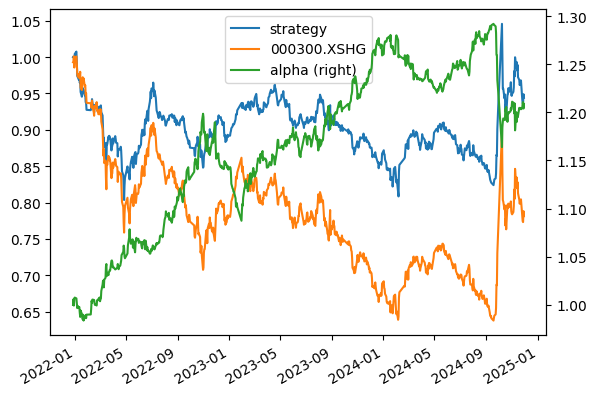

In [28]:
model_name = 'vote_metric_rank'
data_test_total = pd.read_pickle(f'./data/data_test_total_{model_name}.pkl')

# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
df_wight = df_wight.shift(1).dropna(how = 'all')
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result